# GCN
This notebook establishes a training pipeline for our Event Embedding model.

In [ ]:
!git clone https://github.com/dbusbridge/gcn_tutorial

fatal: destination path 'gcn_tutorial' already exists and is not an empty directory.


In [ ]:
!mv gcn_tutorial/* .

mv: cannot stat 'gcn_tutorial/*': No such file or directory


In [ ]:
!pip install tensorflow==1.15.2

In [ ]:
import networkx as nx
import numpy as np
import time

import scipy.sparse

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

import layers.graph as lg
import utils.sparse as us

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [ ]:
!wget https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

--2021-11-10 18:44:06--  https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv.35’

iris.csv.35         100%[===================>]   3.88K  --.-KB/s    in 0s      

2021-11-10 18:44:06 (48.9 MB/s) - ‘iris.csv.35’ saved [3975/3975]



In [ ]:
import pandas as pd

df = pd.read_csv('iris.csv')

In [ ]:
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [ ]:
#Shuffle dataset
df=df.sample(frac=1).reset_index(drop=True)
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.8,4.0,1.2,0.2,Setosa
1,6.1,2.8,4.0,1.3,Versicolor
2,4.6,3.2,1.4,0.2,Setosa
3,5.0,3.2,1.2,0.2,Setosa
4,5.5,2.6,4.4,1.2,Versicolor
...,...,...,...,...,...
145,5.1,3.8,1.6,0.2,Setosa
146,6.9,3.1,5.4,2.1,Virginica
147,6.1,2.6,5.6,1.4,Virginica
148,6.2,2.2,4.5,1.5,Versicolor


In [ ]:
memberships = []
for name in df['variety']:
    if name == 'Setosa':
        memberships.append(0)
    elif name == 'Versicolor':
        memberships.append(1)
    else:
        memberships.append(2)

print(memberships)

[0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2, 1, 0]


In [ ]:
from sklearn.neighbors import kneighbors_graph
#df['memberships'] = memberships
#X = df[['memberships','sepal.length','sepal.width','petal.length','petal.width']]
X = df[['sepal.length','sepal.width','petal.length','petal.width']]
A = kneighbors_graph(X, n_neighbors=7, metric="euclidean")

A.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
X

,sepal.length,sepal.width,petal.length,petal.width
0,5.8,4.0,1.2,0.2
1,6.1,2.8,4.0,1.3
2,4.6,3.2,1.4,0.2
3,5.0,3.2,1.2,0.2
4,5.5,2.6,4.4,1.2
...,...,...,...,...
145,5.1,3.8,1.6,0.2
146,6.9,3.1,5.4,2.1
147,6.1,2.6,5.6,1.4
148,6.2,2.2,4.5,1.5


In [ ]:
X = pd.DataFrame(X).to_numpy()

In [ ]:
g = nx.Graph(A)

"\nmemberships_np = np.array(memberships)\n\nnx.draw(\n     g,\n     node_size=100,\n     cmap=plt.get_cmap('jet'),\n     node_color=np.log(memberships_np))\n"

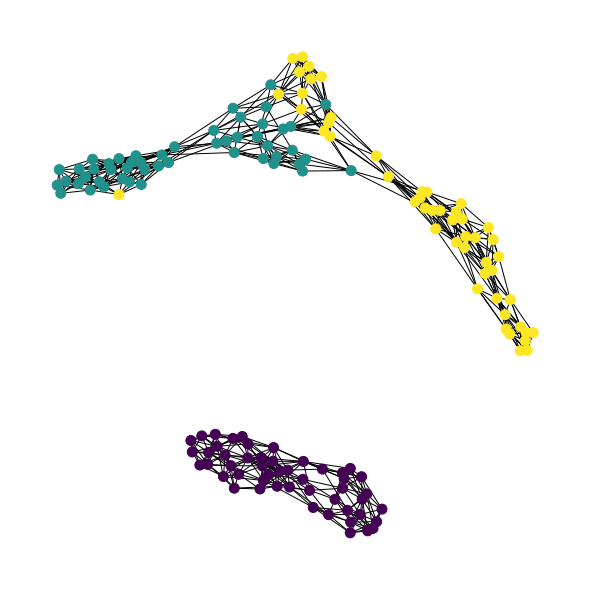

In [ ]:
color_code = {}
colors = []
#for v in list(df['memberships']):
for v in memberships:
  if v not in color_code: color_code[v] = len(color_code)
  colors.append(color_code[v])

plt.figure(figsize=(8,8)) 

nx.draw(g, node_size=100, pos=nx.spring_layout(g), node_color=colors)

'''
memberships_np = np.array(memberships)

nx.draw(
     g,
     node_size=100,
     cmap=plt.get_cmap('jet'),
     node_color=np.log(memberships_np))
'''

In [ ]:
#Remove 2/3 of labels
for i in range(50,150):
  memberships[i] = -1

In [ ]:
import time

import scipy.sparse

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

import layers.graph as lg
import utils.sparse as us

adj = nx.adjacency_matrix(g)

# Get important parameters of adjacency matrix
n_nodes = adj.shape[0]

# Some preprocessing
adj_tilde = adj + np.identity(n=adj.shape[0])
d_tilde_diag = np.squeeze(np.sum(np.array(adj_tilde), axis=1))
d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -1/2)
d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
adj_norm = np.dot(np.dot(d_tilde_inv_sqrt, adj_tilde), d_tilde_inv_sqrt)
adj_norm_tuple = us.sparse_to_tuple(scipy.sparse.coo_matrix(adj_norm))

# Features are just the identity matrix
#feat_x = np.identity(n=adj.shape[0])
feat_x = X
feat_x_tuple = us.sparse_to_tuple(scipy.sparse.coo_matrix(feat_x))

# Semi-supervised
#memberships = [m - 1 for m in nx.get_node_attributes(g, 'variety').values()]
nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]

# Pick one at random from each class
labels_to_keep = [np.random.choice(
    np.nonzero(one_hot_targets[:, c])[0]) for c in range(nb_classes)]

y_train = np.zeros(shape=one_hot_targets.shape,
                   dtype=np.float32)
y_val = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=np.bool)
val_mask = np.ones(shape=(n_nodes,), dtype=np.bool)

for l in labels_to_keep:
    y_train[l, :] = one_hot_targets[l, :]
    y_val[l, :] = np.zeros(shape=(nb_classes,))
    train_mask[l] = True
    val_mask[l] = False


# TensorFlow placeholders
ph = {
    'adj_norm': tf.sparse_placeholder(tf.float32, name="adj_mat"),
    'x': tf.sparse_placeholder(tf.float32, name="x"),
    'labels': tf.placeholder(tf.float32, shape=(n_nodes, nb_classes)),
    'mask': tf.placeholder(tf.int32)}

In [ ]:
l_sizes = [8, 4, 2, nb_classes]

o_fc1 = lg.GraphConvLayer(
    input_dim=feat_x.shape[-1],
    output_dim=l_sizes[0],
    name='fc1',
    activation=tf.nn.tanh)(adj_norm=ph['adj_norm'], x=ph['x'], sparse=True)

o_fc2 = lg.GraphConvLayer(
    input_dim=l_sizes[0],
    output_dim=l_sizes[1],
    name='fc2',
    activation=tf.nn.tanh)(adj_norm=ph['adj_norm'], x=o_fc1)

o_fc3 = lg.GraphConvLayer(
    input_dim=l_sizes[1],
    output_dim=l_sizes[2],
    name='fc3',
    activation=tf.nn.tanh)(adj_norm=ph['adj_norm'], x=o_fc2)

o_fc4 = lg.GraphConvLayer(
    input_dim=l_sizes[2],
    output_dim=l_sizes[3],
    name='fc4',
    activation=tf.identity)(adj_norm=ph['adj_norm'], x=o_fc3)


with tf.name_scope('optimizer'):
    loss = masked_softmax_cross_entropy(
        preds=o_fc4, labels=ph['labels'], mask=ph['mask'])

    accuracy = masked_accuracy(
        preds=o_fc4, labels=ph['labels'], mask=ph['mask'])

    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)

    opt_op = optimizer.minimize(loss)

feed_dict_train = {ph['adj_norm']: adj_norm_tuple,
                   ph['x']: feat_x_tuple,
                   ph['labels']: y_train,
                   ph['mask']: train_mask}

feed_dict_val = {ph['adj_norm']: adj_norm_tuple,
                 ph['x']: feat_x_tuple,
                 ph['labels']: y_val,
                 ph['mask']: val_mask}

sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 31
save_every = 6

t = time.time()
outputs = {}
# Train model
for epoch in range(epochs):
    # Construct feed dictionary

    # Training step
    _, train_loss, train_acc = sess.run(
        (opt_op, loss, accuracy), feed_dict=feed_dict_train)

    if epoch % save_every == 0:
        # Validation
        val_loss, val_acc = sess.run((loss, accuracy), feed_dict=feed_dict_val)

        # Print results
        print("Epoch:", '%04d' % (epoch + 1),
              "train_loss=", "{:.5f}".format(train_loss),
              "train_acc=", "{:.5f}".format(train_acc),
              "val_loss=", "{:.5f}".format(val_loss),
              "val_acc=", "{:.5f}".format(val_acc),
              "time=", "{:.5f}".format(time.time() - t))

        feed_dict_output = {ph['adj_norm']: adj_norm_tuple,
                            ph['x']: feat_x_tuple}

        output = sess.run(o_fc3, feed_dict=feed_dict_output)
        outputs[epoch] = output




Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 0001 train_loss= 1.52874 train_acc= 0.00000 val_loss= 1.48419 val_acc= 0.00000 time= 0.09397
Epoch: 0007 train_loss= 1.38918 train_acc= 0.25000 val_loss= 1.38082 val_acc= 0.11644 time= 0.11846
Epoch: 0013 train_loss= 1.37267 train_acc= 0.50000 val_loss= 1.34983 val_acc= 0.32192 time= 0.13578
Epoch: 0019 train_loss= 1.35665 train_acc= 0.25000 val_loss= 1.36859 val_acc= 0.11644 time= 0.15046
Epoch: 0025 train_loss= 1.32685 train_acc= 0.25000 val_loss= 1.34590 val_acc= 0.24658 time= 0.16519
Epoch: 0031 train_loss= 1.28015 train_acc= 0.50000 val_loss= 1.32981 val_acc= 0.24658 time= 0.17942


In [ ]:
outputs

{0: array([[ 0.7035363 , -0.04504783],
        [ 0.31074694, -0.05242579],
        [ 0.77102757, -0.08598739],
        [ 0.68799996, -0.0623311 ],
        [ 0.27869898, -0.06033631],
        [ 0.22927804, -0.05837391],
        [ 0.16628577, -0.0323007 ],
        [-0.21051085,  0.02639351],
        [ 0.734694  , -0.08225858],
        [ 0.69122046, -0.06216097],
        [ 0.33561867, -0.05714279],
        [ 0.24418709, -0.05589778],
        [-0.25328156,  0.03687762],
        [-0.22562975,  0.03192959],
        [ 0.36469433, -0.06336729],
        [-0.18654333,  0.02124436],
        [ 0.3110586 , -0.05967773],
        [-0.19778574,  0.03609088],
        [-0.2738566 ,  0.04101392],
        [ 0.42828634, -0.07080805],
        [-0.18747142,  0.03046937],
        [ 0.36465064, -0.057942  ],
        [ 0.14295371, -0.03605618],
        [ 0.77032864, -0.04649237],
        [ 0.39008814, -0.06837337],
        [-0.291842  ,  0.04545318],
        [-0.30283654,  0.04632779],
        [ 0.24133562, -0.

# Sugestões:

* Tente treinar com menos épocas, pois é um dataset pequeno.
* Na hora do membership, utilize um máximo de 20% de informação de rótulo para os vértices, para ficar mais próximo a um contexto real (entendi que você está usando 100%). Quem não tem rótulo, coloque membership = -1.

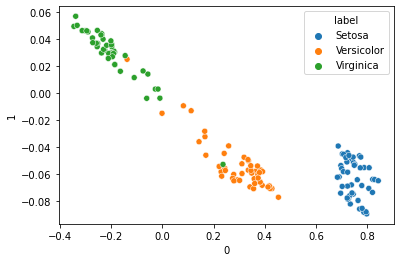

In [ ]:
import seaborn as sns

df2 = pd.DataFrame(outputs[0])
df2['label'] = df.variety
sns.scatterplot(data=df2, x=0, y=1, hue="label")

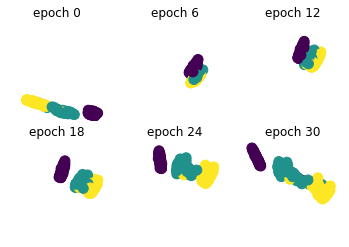

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [ ]:
node_positions = {o: {n: tuple(outputs[o][j])
                      for j, n in enumerate(nx.nodes(g))}
                  for o in outputs}
plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

# Two subplots, unpack the axes array immediately
f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

e = list(node_positions.keys())


for i, ax in enumerate(axes.flat):
    pos = node_positions[e[i]]
    ax.set_title(plot_titles[e[i]])
    
    plt.figure(figsize=(8,8)) 

    #nx.draw(g, cmap=plt.get_cmap('jet'), node_size=100,  node_color=np.log(memberships_np + 1), pos = pos, ax = ax)
    #nx.draw(g, cmap=plt.get_cmap('jet'), node_size=100,  node_color=np.log(memberships_np + 1), pos = pos)
    nx.draw(g, node_size=100, pos=pos, node_color=colors,ax=ax)

plt.show()